In [ ]:
# 支持执行一次反向的函数不一定具备支持双重反向的功能。在本教程中，我们将展示如何编写支持双重反向的自定义自动求导函数，并指出一些需要注意的事项。

In [ ]:
# 当 autograd 能够记录反向传播中的操作时，双重反向传播会自动工作，因此当我们保存反向传播的输入时通常无需担心，因为如果输入是任何需要 grad 的张量的函数，则输入应该具有 grad_fn。这允许梯度正确传播。
# 保存输入
import torch

class Square(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        # Because we are saving one of the inputs use `save_for_backward`
        # Save non-tensors and non-inputs/non-outputs directly on ctx
        ctx.save_for_backward(x)
        return x**2

    @staticmethod
    def backward(ctx, grad_out):
        # A function support double backward automatically if autograd
        # is able to record the computations performed in backward
        x, = ctx.saved_tensors
        return grad_out * 2 * x

# Use double precision because finite differencing method magnifies errors
x = torch.rand(3, 3, requires_grad=True, dtype=torch.double)
torch.autograd.gradcheck(Square.apply, x)
# Use gradcheck to verify second-order derivatives
torch.autograd.gradgradcheck(Square.apply, x)

True

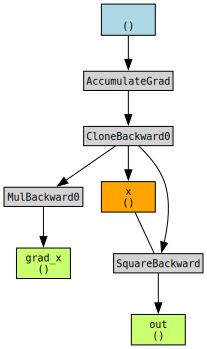

In [5]:
import torchviz

x = torch.tensor(1., requires_grad=True).clone()
out = Square.apply(x)
grad_x, = torch.autograd.grad(out, x, create_graph=True)
torchviz.make_dot((grad_x, x, out), {"grad_x": grad_x, "x": x, "out": out})

In [6]:
# 保存输出
class Exp(torch.autograd.Function):
    # Simple case where everything goes well
    @staticmethod
    def forward(ctx, x):
        # This time we save the output
        result = torch.exp(x)
        # Note that we should use `save_for_backward` here when
        # the tensor saved is an ouptut (or an input).
        ctx.save_for_backward(result)
        return result

    @staticmethod
    def backward(ctx, grad_out):
        result, = ctx.saved_tensors
        return result * grad_out

x = torch.tensor(1., requires_grad=True, dtype=torch.double).clone()
# Validate our gradients using gradcheck
torch.autograd.gradcheck(Exp.apply, x)
torch.autograd.gradgradcheck(Exp.apply, x)

True

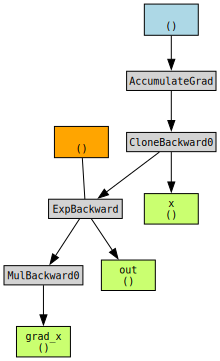

In [7]:
out = Exp.apply(x)
grad_x, = torch.autograd.grad(out, x, create_graph=True)
torchviz.make_dot((grad_x, x, out), {"grad_x": grad_x, "x": x, "out": out})

In [8]:
# 保存中间量
class Sinh(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        expx = torch.exp(x)
        expnegx = torch.exp(-x)
        ctx.save_for_backward(expx, expnegx)
        # In order to be able to save the intermediate results, a trick is to
        # include them as our outputs, so that the backward graph is constructed
        return (expx - expnegx) / 2, expx, expnegx

    @staticmethod
    def backward(ctx, grad_out, _grad_out_exp, _grad_out_negexp):
        expx, expnegx = ctx.saved_tensors
        grad_input = grad_out * (expx + expnegx) / 2
        # We cannot skip accumulating these even though we won't use the outputs
        # directly. They will be used later in the second backward.
        grad_input += _grad_out_exp * expx
        grad_input -= _grad_out_negexp * expnegx
        return grad_input

def sinh(x):
    # Create a wrapper that only returns the first output
    return Sinh.apply(x)[0]

x = torch.rand(3, 3, requires_grad=True, dtype=torch.double)
torch.autograd.gradcheck(sinh, x)
torch.autograd.gradgradcheck(sinh, x)

True

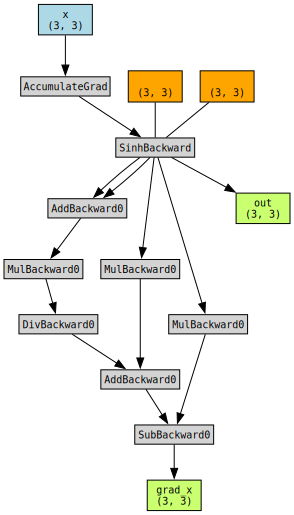

In [9]:
out = sinh(x)
grad_x, = torch.autograd.grad(out.sum(), x, create_graph=True)
torchviz.make_dot((grad_x, x, out), params={"grad_x": grad_x, "x": x, "out": out})

In [10]:
# 保存中间结果：不该做什么
# 现在我们展示当我们不返回中间结果作为输出时会发生什么：grad_x甚至不会有后向图，因为它纯粹是一个函数exp和expnegx，不需要 grad。
class SinhBad(torch.autograd.Function):
    # This is an example of what NOT to do!
    @staticmethod
    def forward(ctx, x):
        expx = torch.exp(x)
        expnegx = torch.exp(-x)
        ctx.expx = expx
        ctx.expnegx = expnegx
        return (expx - expnegx) / 2

    @staticmethod
    def backward(ctx, grad_out):
        expx = ctx.expx
        expnegx = ctx.expnegx
        grad_input = grad_out * (expx + expnegx) / 2
        return grad_input

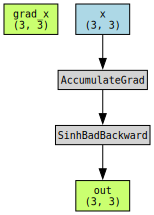

In [11]:
# 使用 torchviz 可视化图表。请注意，grad_x不是图表的一部分！
out = SinhBad.apply(x)
grad_x, = torch.autograd.grad(out.sum(), x, create_graph=True)
torchviz.make_dot((grad_x, x, out), params={"grad_x": grad_x, "x": x, "out": out})

In [12]:
# 当没有跟踪回溯时
# 最后，让我们考虑一个例子，其中 autograd 可能根本无法跟踪函数的梯度。我们可以想象 cube_backward 是一个可能需要非 PyTorch 库（如 SciPy 或 NumPy）的函数，或者以 C++ 扩展的形式编写。这里演示的解决方法是创建另一个自定义函数 CubeBackward，您还可以手动指定 cube_backward 的后向！

In [13]:
def cube_forward(x):
    return x**3

def cube_backward(grad_out, x):
    return grad_out * 3 * x**2

def cube_backward_backward(grad_out, sav_grad_out, x):
    return grad_out * sav_grad_out * 6 * x

def cube_backward_backward_grad_out(grad_out, x):
    return grad_out * 3 * x**2

class Cube(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return cube_forward(x)

    @staticmethod
    def backward(ctx, grad_out):
        x, = ctx.saved_tensors
        return CubeBackward.apply(grad_out, x)

class CubeBackward(torch.autograd.Function):
    @staticmethod
    def forward(ctx, grad_out, x):
        ctx.save_for_backward(x, grad_out)
        return cube_backward(grad_out, x)

    @staticmethod
    def backward(ctx, grad_out):
        x, sav_grad_out = ctx.saved_tensors
        dx = cube_backward_backward(grad_out, sav_grad_out, x)
        dgrad_out = cube_backward_backward_grad_out(grad_out, x)
        return dgrad_out, dx

x = torch.tensor(2., requires_grad=True, dtype=torch.double)

torch.autograd.gradcheck(Cube.apply, x)
torch.autograd.gradgradcheck(Cube.apply, x)

True

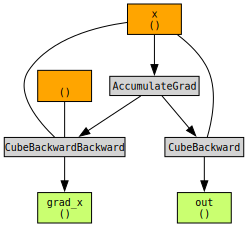

In [14]:
out = Cube.apply(x)
grad_x, = torch.autograd.grad(out, x, create_graph=True)
torchviz.make_dot((grad_x, x, out), params={"grad_x": grad_x, "x": x, "out": out})

In [ ]:
# 总而言之，双重反向是否适用于您的自定义函数仅取决于反向传递是否可以通过 autograd 进行跟踪。通过前两个示例，我们展示了双重反向开箱即用的情况。通过第三和第四个示例，我们演示了使反向函数能够被跟踪的技术，否则它们将无法被跟踪。